In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

In normal NEF, it is common to do PCA on the tuning curves of the neurons in order to figure out what classes of functions those neurons might be good at computing.

In more recent times, we're starting to think about neurons having temporal tuning curves.  The standard PCA approach above collapses data over time.  So can we do a similar process, but without collapsing over time?  If we could do this, we could take any neural system with temporal dynamics and determine what class of (temporal) functions it would be good at computing.

To explore this, let's start with a system with neurons where we know exactly what the temporal tuning curves are, and let's even go so far as to simplify everything to a linear system.  In other words, let's try this out with an LDN.  This is a linear recurrent reservoir where the temporal responses of the "neurons" are scaled versions of the legendre polynomials over a particular window in time `theta`, and then the responses drop to zero after that time https://papers.nips.cc/paper_files/paper/2019/file/952285b9b7e7a1be5aa7849f32ffff05-Paper.pdf .  This is meant to be an ideal reservoir for storing data over the past `theta` seconds.  The parameter `q` indicates how many neurons are used (i.e. the dimensionality of the internal state).  The LDN uses linear neurons, so this is simply a system of the form $\dot x = Ax + Bu$.

In [74]:
import scipy.linalg

class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices A and B so that
        #  dx/dt = Ax + Bu will convert u into a legendre representation over a window theta
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        A = np.zeros((q, q))
        B = np.zeros((q, 1))
        for i in range(q):
            B[i] = (-1.)**i * (2*i+1)
            for j in range(q):
                A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1)) 
        self.A = A / theta
        self.B = B / theta        
        
        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

Let's plot the impulse response compared to the ideal Legendre polynomials, just to make sure this works.

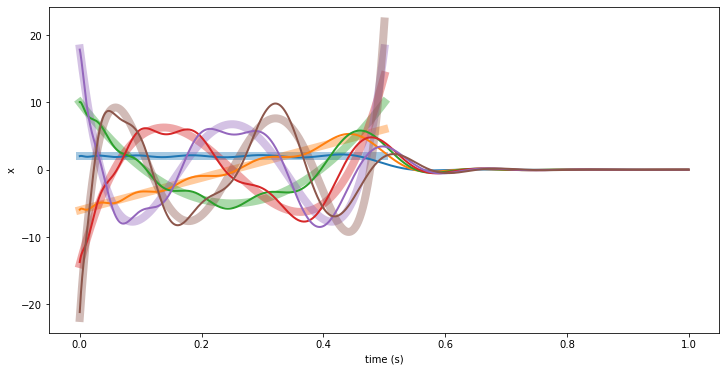

In [415]:
ldn = LDN(theta=0.5, q=12)

# create an impulse input (i.e. an input of area one that is only non-zero on the first timestep)
T = 1.0
dt = 0.001
u = np.zeros((int(T/dt), 1))
u[0,0] = 1/dt

# run the system
x = ldn.apply(u, dt=dt)

# plot the results, compared to the ideal scaled Legendre polynomials
t = np.arange(int(T/dt))*dt

plt.figure(figsize=(12,6))
from scipy.special import legendre
for i in range(6):
    plt.plot(np.linspace(0, ldn.theta, 1000), (2*i+1)/ldn.theta*legendre(i)(np.linspace(-1,1,1000)), lw=8, alpha=0.4)
plt.gca().set_prop_cycle(None)
for i in range(6):
    plt.plot(t, x[:,i], lw=2)
plt.xlabel('time (s)')
plt.ylabel('x')
plt.show()

I can also build a reservoir of nonlinear neurons that approximates this ideal linear reservoir.  Here I use 1000 LIF (rate-mode) neurons and train the network to approximate the same dynamical system.  The idea here is that the 1000 neurons will represent a `q`-dimensional subspace that's the same as the original linear system.

In [416]:
import nengo
model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: 1/dt if t<=dt else 0)
    ens = nengo.Ensemble(n_neurons=1000, dimensions=ldn.q,
                         intercepts=nengo.dists.CosineSimilarity(ldn.q+2),
                         neuron_type=nengo.LIFRate(), radius=20,
                         seed=0)
    tau = 0.2
    nengo.Connection(ens, ens, transform=ldn.A*tau+np.eye(ldn.q), synapse=tau)
    nengo.Connection(stim, ens, transform=ldn.B*tau, synapse=tau)
    
    p_neurons = nengo.Probe(ens.neurons)
    p_state = nengo.Probe(ens)
sim = nengo.Simulator(model)
with sim:
    sim.run(1.0)
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

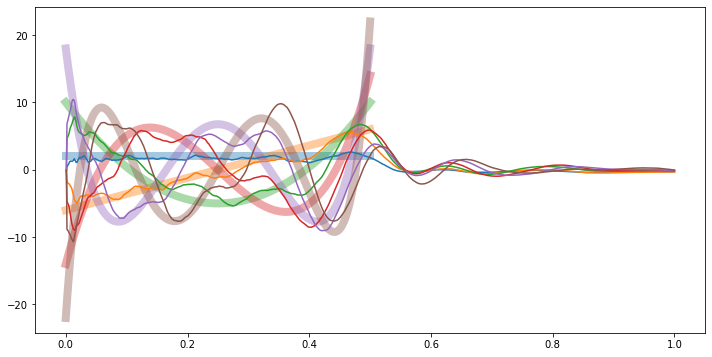

In [417]:
plt.figure(figsize=(12,6))

for i in range(6):
    plt.plot(np.linspace(0, ldn.theta, 1000), 2*(2*i+1)*legendre(i)(np.linspace(-1,1,1000)), lw=8, alpha=0.4)
plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), sim.data[p_state][:,:6])
plt.show()

However, that above plot is a plot of the q-dimensional subspace that is represented by the neurons.  I only know how to decode that if I'm manually building that network.  If someone just gives me a reservoir and asks me to analyze it, the real data I have is just the behaviour of the neurons.  Here's what that looks like:

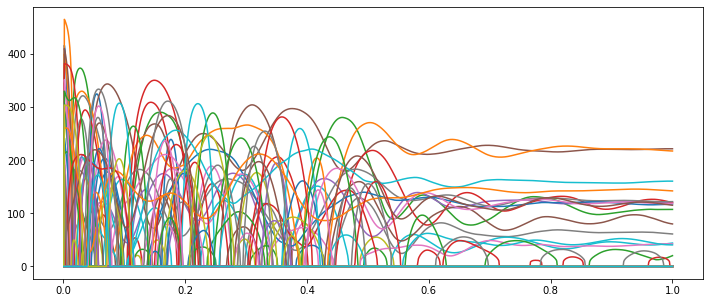

In [418]:
plt.figure(figsize=(12,5))
plt.plot(sim.trange(), sim.data[p_neurons][:,:50])
plt.ylim
plt.show()

That's horrible, and that's only showing the first 50 neurons.  What can we do here?

Well, if we do believe that these neurons are encoding information in a distributed manner, then let's try finding that subspace.  In particular, let's do PCA on the neural responses and see what we get.  For comparison, let's also do the same approach to the ideal decoded state data as well.

In [419]:
import sklearn.decomposition

pca_state  = sklearn.decomposition.PCA(n_components=12)
pca_state.fit(sim.data[p_state])
d_state = pca_state.transform(sim.data[p_state])

pca_neurons  = sklearn.decomposition.PCA(n_components=12)
pca_neurons.fit(sim.data[p_neurons])
d_neurons = pca_neurons.transform(sim.data[p_neurons])



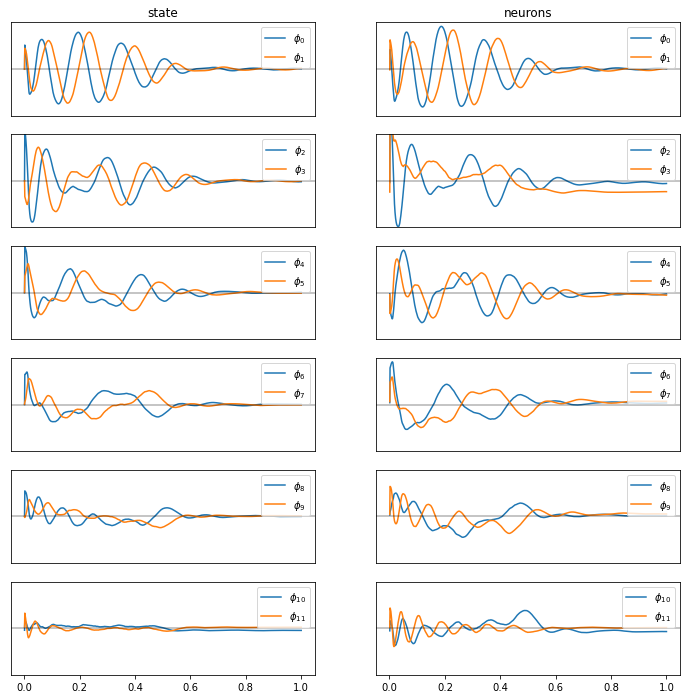

In [420]:
plt.figure(figsize=(12,12))
M = 6
for i in range(M):
    plt.subplot(M, 2, 1+2*i)
    plt.plot(sim.trange(), d_state[:,2*i:2*i+2])
    plt.axhline(0, c='k', alpha=0.3)    
    plt.ylim(-20, 20)
    plt.yticks([])
    plt.legend([f'$\phi_{{{2*i}}}$', f'$\phi_{{{2*i+1}}}$'], loc='upper right')
    if i==0:
        plt.title('state')
    if i<M-1:
        plt.xticks([])
    plt.subplot(M, 2, 2+2*i)
    plt.plot(sim.trange(), d_neurons[:,2*i:2*i+2])
    plt.axhline(0, c='k', alpha=0.3)
    plt.ylim(-2000, 2000)
    plt.yticks([])
    plt.legend([f'$\phi_{{{2*i}}}$', f'$\phi_{{{2*i+1}}}$'], loc='upper right')
    if i<M-1:
        plt.xticks([])
    if i==0:
        plt.title('neurons')
    



The plots above show the first 12 principle components for the state data (left) and the neural data (right).  I'm plotting them in groups of two partly just for space reasons, but also because there does seem to be some nice complementarity for at least some of them, interms of being approximately 90 degrees out of phase with each other.

I'm not quite sure what else could be done here.  Maybe do some curve fitting and figure out what family of curves these might be?  I was really hoping that the Legendre polynomials would fall out for both versions, but that doesn't seem to be the case for either.

# Randomized inputs

Rather than using an impulse response, we should probably also look at the system's behaviour for more realistic inputs.  After all, using the impulse response only makes sense for a linear system (which the ideal LDN is, but the version with neurons or any realistic reservoir generally won't be).

What we're going to do is feed in a random signal that's much longer than the impulse we've been feeding in before.  Then we'll chop up the resulting data into 1-second long chunks and do PCA over that temporal data and see what components we get.  Again, we'll do this both for the ideal state-space data and for the raw neural data.

In [421]:
T = 50

import nengo
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=T, high=10))
    ens = nengo.Ensemble(n_neurons=1000, dimensions=ldn.q,
                         intercepts=nengo.dists.CosineSimilarity(ldn.q+2),
                         neuron_type=nengo.LIFRate(), radius=20,
                         seed=0)
    tau = 0.2
    nengo.Connection(ens, ens, transform=ldn.A*tau+np.eye(ldn.q), synapse=tau)
    nengo.Connection(stim, ens, transform=ldn.B*tau, synapse=tau)
    
    p_stim = nengo.Probe(stim)
    p_neurons = nengo.Probe(ens.neurons)
    p_state = nengo.Probe(ens)
sim = nengo.Simulator(model)
with sim:
    sim.run(T)
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [422]:
d_state = sim.data[p_state]
d_state = np.lib.stride_tricks.sliding_window_view(d_state.T, 1000, axis=1)
d_state = d_state[:,::100,:].reshape((-1, 1000))

d_neurons = sim.data[p_neurons]
d_neurons = np.lib.stride_tricks.sliding_window_view(d_neurons.T, 1000, axis=1)
d_neurons = d_neurons[:,::100,:].reshape((-1, 1000))


import sklearn.decomposition

pca_state  = sklearn.decomposition.PCA(n_components=12)
pca_state.fit(d_state)
d_state = pca_state.components_.T

pca_neurons  = sklearn.decomposition.PCA(n_components=13)
pca_neurons.fit(d_neurons)
d_neurons = pca_neurons.components_.T


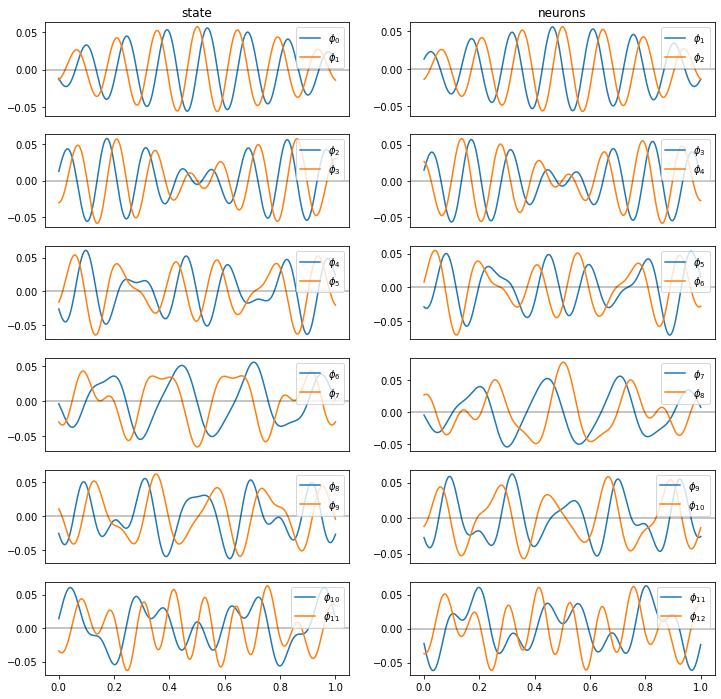

In [423]:
plt.figure(figsize=(12,12))
M = 6
for i in range(M):
    plt.subplot(M, 2, 1+2*i)
    plt.plot(sim.trange()[:1000], d_state[:,2*i:2*i+2])
    plt.axhline(0, c='k', alpha=0.3)    
    plt.legend([f'$\phi_{{{2*i}}}$', f'$\phi_{{{2*i+1}}}$'], loc='upper right')
    if i==0:
        plt.title('state')
    if i<M-1:
        plt.xticks([])
    plt.subplot(M, 2, 2+2*i)
    plt.plot(sim.trange()[:1000], d_neurons[:,2*i+1:2*i+2+1])
    plt.axhline(0, c='k', alpha=0.3)
    plt.legend([f'$\phi_{{{2*i+1}}}$', f'$\phi_{{{2*i+2}}}$'], loc='upper right')
    if i<M-1:
        plt.xticks([])
    if i==0:
        plt.title('neurons')
    



Well, on the one hand it's great that we're getting very similar responses for the neural data and the state-space data.  But, one big thing that has happened here is that these resulting temporal responses do not decay to zero after about 0.5 seconds!  This is a problem because we know that this particular reservoir loses all information after about 0.5 seconds, but this analysis is not revealing that basic feature.

My initial guess was that this is because this analysis is being given random band-limited what noise inputs with a maimum frequency of 10Hz.  This means there is temporal correlation in the inputs that last longer than 0.5 seconds.  So I tried with band-limited white noise with a lower bound of 3Hz...  Unfortunately, that didn't change the results at all.  So now I have no idea why this loses that information that there's no memory past 0.5 seconds.

# Recovering Temporal Information

As another thing to try, let's use Dynamic Mode Decomposition.  This is a tool that should, given a system, try to identify a small set of temporal dynamics that explain the system.  This seems to be what we might want here.  In particular, let's use DMD with control, which attempts to find a system of the form $\dot x = Ax + Bu$ that explains a given set of $x$ and $u$ data.  There's a tutorial here https://github.com/mathLab/PyDMD/blob/master/tutorials/tutorial7/tutorial-7-dmdc.ipynb

To do this, we'll start by taking the neural data and doing (non-temporal) PCA on it to reduce the dimensionality

In [424]:
pca = sklearn.decomposition.PCA(n_components=50)
pca.fit(sim.data[p_neurons])
d = pca.transform(sim.data[p_neurons])


Now we give the compressed neural data to DMD as $x$, along with the input signal $u$, and it will try to find the values of $A$ and $B$ that will make $\dot x = Ax+Bu$ fit the data.

In [425]:
import pydmd
dmdc = pydmd.DMDc(svd_rank=-1)
dmdc.fit(d.T, sim.data[p_stim].T[:,1:])
d_hat = dmdc.reconstructed_data().real.T

How well does it fit the data?


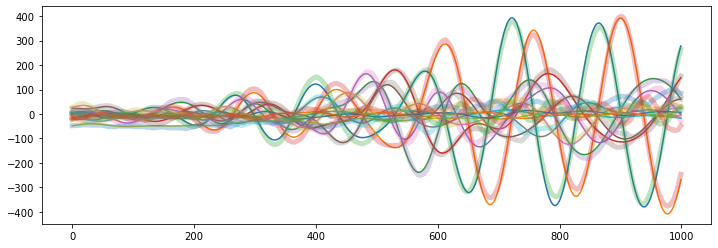

In [426]:
plt.figure(figsize=(12,4))
M = 1000
Q = 12
plt.plot(d_hat[:M,:Q])
plt.plot(d[:M,:Q], lw=5, alpha=0.3)
plt.show()

That looks like a very good fit to me.  So it's found a linear system that does a pretty good job of approximating our reservoir.  Now, given that discovered linear system, let's give it an impulse input and see what the response is!

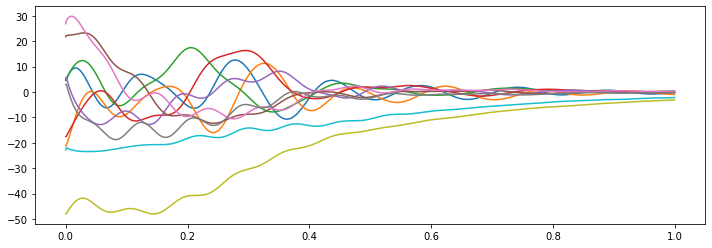

In [430]:
new_u = np.zeros_like(sim.data[p_stim].T[:,1:])
new_u[0,0] = 1

impulse = dmdc.reconstructed_data(new_u).real
plt.figure(figsize=(12,4))
plt.plot(np.arange(1000)*dt, impulse[:10,:1000].T)
plt.show()

Now this looks like it's showing us that the responses decay away after about 0.5 seconds!  So it is possible to recover that aspect of the dynamics of the system when we're in the context of continual random input.

# Next steps

Where do we go from here?  Are there better ways of doing this?  Other approaches?  Are there other ways to think of these temporal responses?  Have I messed up math here?